# Correlations and linear models
A linear model estimate a response from the linear combination of one or more inputs

$y \approx x_1 \alpha_1 + y_2 \alpha_2 + ... + y_n \alpha_n$

$y \approx \vec{x} \cdot \vec{\alpha}$

given an estimation $\hat{y} = \vec{x} \cdot \vec{\alpha}$

we look for the best $\vec{\alpha}$ which minimize all residuals $\epsilon(\hat{y}) = y - \hat{y}$

In [1]:
import pandas as pd

This dataset collects the yearly water and energy consuption estimation per capita in Milan collected by the italian government

Data is grouped by 

- water consumption
- methan consumption
- electricity consumption

In [2]:
cons = pd.read_csv("ds523_consumoacquaenergia.csv",sep=";")

In [3]:
cons.describe(include="all")

,anno,Consumo pro capite tipo,Consumo pro capite
count,36.00000,36,36.000000
unique,NaN,3,NaN
top,NaN,Energia elettrica per uso domestico,NaN
freq,NaN,12,NaN
mean,2005.50000,NaN,573.072222
std,3.50102,NaN,471.777743
min,2000.00000,NaN,80.400000
25%,2002.75000,NaN,89.625000
50%,2005.50000,NaN,432.900000
75%,2008.25000,NaN,1195.650000


In [4]:
cons["Consumo pro capite tipo"].unique()

array(['Energia elettrica per uso domestico',
       'Gas metano per uso domestico e riscaldamento',
       'Acqua fatturata per uso domestico'], dtype=object)

In [5]:
translate = {
    'Energia elettrica per uso domestico':'electricity',
    'Gas metano per uso domestico e riscaldamento':'methan',
    'Acqua fatturata per uso domestico':'water'
}
cons["type"] = cons["Consumo pro capite tipo"].map(translate)

In [6]:
cons2 = cons.pivot(index="anno",columns="type",values="Consumo pro capite").reset_index()
cons2 = cons2.rename({"anno":"year"}, axis="columns")
cons2

type,year,electricity,methan,water
0,2000,1130.2,509.0,92.1
1,2001,1143.9,500.7,91.3
2,2002,1195.5,504.2,90.4
3,2003,1222.8,480.2,87.3
4,2004,1228.6,442.4,80.4
5,2005,1225.0,434.5,81.3
6,2006,1219.7,431.3,82.2
7,2007,1197.0,381.1,81.6
8,2008,1203.0,384.9,84.5
9,2009,1202.9,389.6,85.8


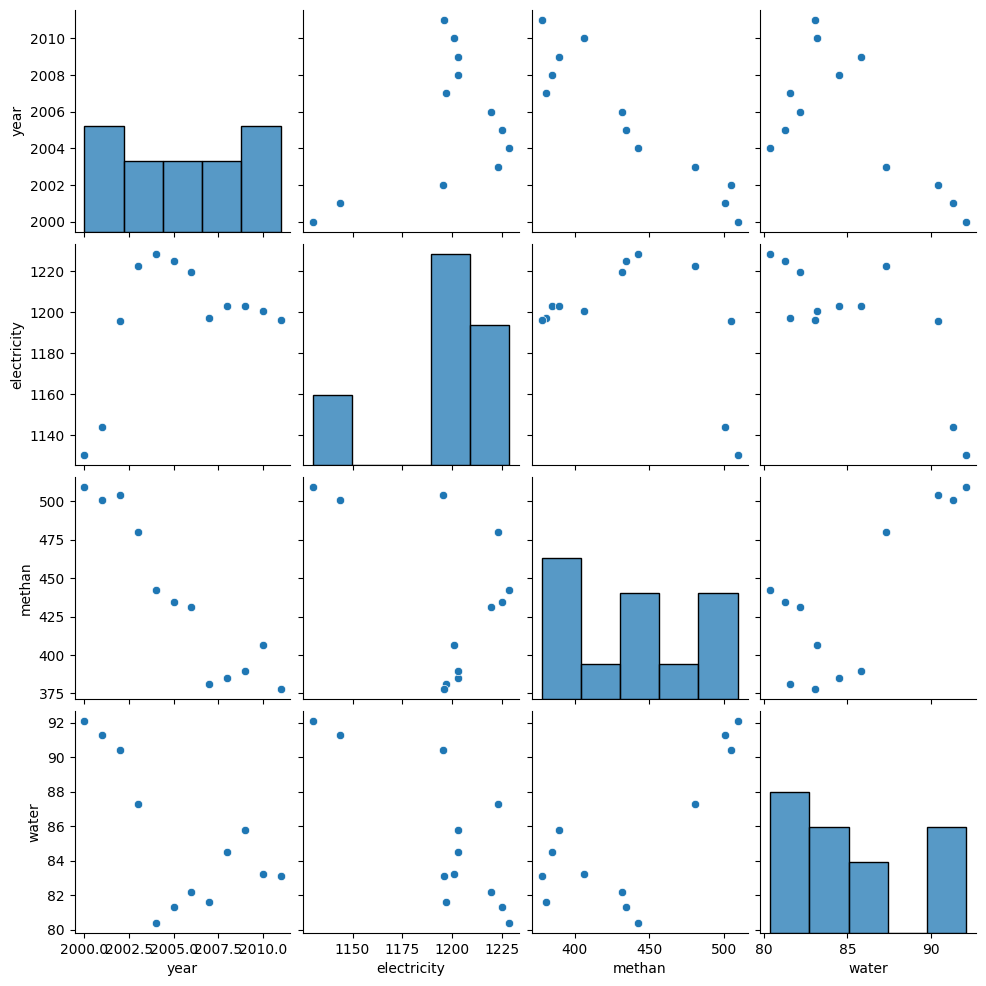

In [8]:
import seaborn as sns
sns.pairplot(cons2)

<Axes: xlabel='year', ylabel='methan'>

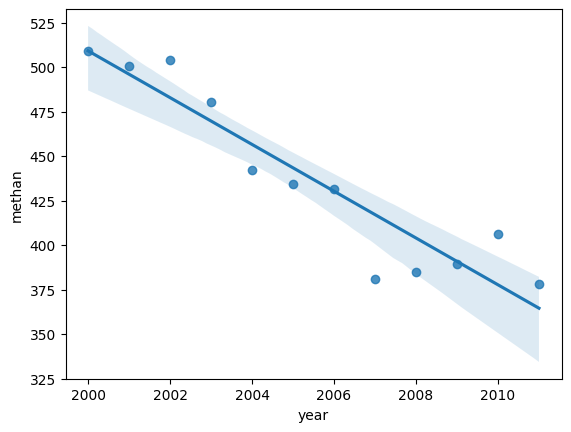

In [12]:
sns.regplot(cons2,x="year",y="methan")

## Covariance and correlation

The [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix), defined as

$cov[X_i, X_j] = E[(X_i - E[X_i])(X_j - E[X_j])]$

is the multidimensional extension of the variance, elements of the diagonal being the variance of the corrisponding dimension; its eigenvectors define an ellipsoid representing the most important combinations of the dimensional features; this is used in Principal Compaonent Analysis, a technique which helps to define the most impactful features.

By dividing each element with the product of the standard deviations we have the [correlation matrix](https://en.wikipedia.org/wiki/Correlation)

$corr[X_i, X_j] = \frac{E[(X_i - E[X_i])(X_j - E[X_j])]}{\sigma_i\sigma_j}$

The elements outside the diagonal are numbers between -1 and 1; 0 represents no correlation (like a spherical cloud) while 1 and -1 represent positive and negative correlation respectively; this gives us a first estimation of the possible linear dependecies within a set of observation features

In [17]:
import numpy as np
# numpy expects a matrix where each feature is in a row instead of a column
# thus we need to transpose it
np.corrcoef(np.transpose(np.array(cons2)))

array([[ 1.        ,  0.44786015, -0.93548315, -0.65540971],
       [ 0.44786015,  1.        , -0.46029677, -0.77514369],
       [-0.93548315, -0.46029677,  1.        ,  0.75208366],
       [-0.65540971, -0.77514369,  0.75208366,  1.        ]])

we can see that the negative correlation between year and methan is about -0.9 which makes it a good candidate for a linear correlation

In [18]:
from scipy import stats

## Regression calculation
in this simple case we have 
- few observations
- only one input value
so we may directly use the [Ordinary Least Squares regression method](https://en.wikipedia.org/wiki/Ordinary_least_squares) to evaluate the best fit

In [19]:
result = stats.linregress(x=cons2.year, y=cons2.methan)
result

LinregressResult(slope=np.float64(-13.141258741258738), intercept=np.float64(26791.62773892773), rvalue=np.float64(-0.9354831530794605), pvalue=np.float64(7.894692952340761e-06), stderr=np.float64(1.5697563928623894), intercept_stderr=np.float64(3148.151109622701))

the returned object contains some interesting values; let's check the first two:
- slope
- intercept
  
allows us to write a simple prediction formula

In [27]:
def predict_methan(year):
    return result.slope * year + result.intercept


with this formula we can build a chart of our linear regression

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

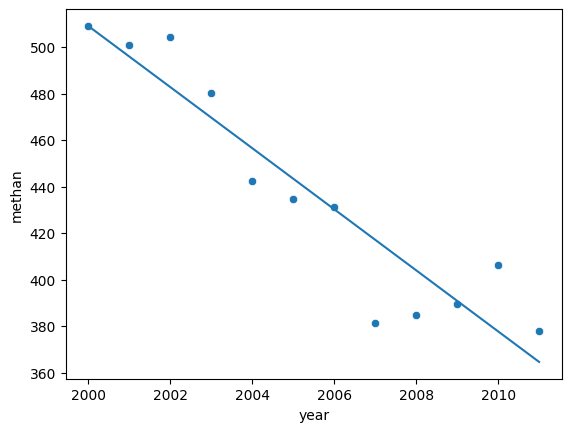

In [32]:
# create a plot canvas
fig, ax = plt.subplots(1,1)

#first plot the points into our canvas
sns.scatterplot(x=cons2.year, y=cons2.methan, ax=ax)

# then plot a line from the first to the last point on the same canvas
year0 = min(cons2.year)
year1 = max(cons2.year)
ax.plot((year0,year1),(predict_methan(year0),predict_methan(year1)))

note: the polymorphism allows to properly use the prodict_methan function also with pandas Series

## Assessing the qaulity of a regression

In [30]:
residuals = cons2.methan - predict_methan(cons2.year)

looking at residuals distribution may show some pattern; in this case we may assume there is a better way to represent the relation between the features under investigation.

In our example looks like there is no apparent pattern

<Axes: xlabel='year', ylabel='None'>

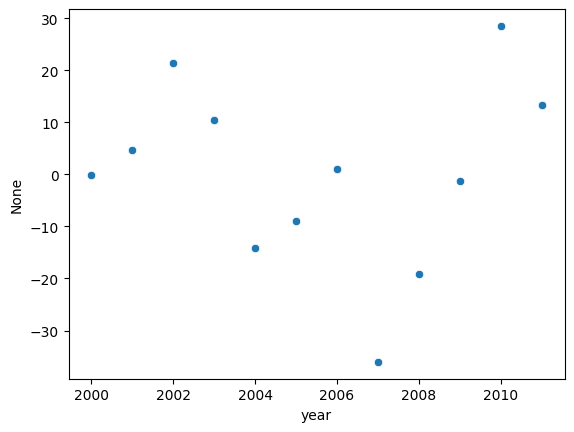

In [31]:
sns.scatterplot(x=cons2.year, y=residuals)

The next step would be to assess the variance of residuals respect to the total variance of the distribution of the output variable Y:

\begin{equation}
\frac{var[\epsilon]}{var[Y]} = \frac{E[(\epsilon - E[\epsilon])^2]}{E[(Y - E[Y])^2]}
\end{equation}

let's use $\hat{Y}$ to represent the predicted values;
by knowing that the mean of the residuals is 0 and their definition 

\begin{equation}
E[\epsilon] = 0
\end{equation}

\begin{equation}
\epsilon = Y - \hat{Y}
\end{equation}

we have

\begin{equation}
\frac{var[\epsilon]}{var[Y]} = \frac{E[(Y - \hat{Y})^2]}{E[(Y - E[Y])^2]}
\end{equation}

now the quantity

\begin{equation}
R^2 = 1 - \frac{E[(Y - \hat{Y})^2]}{E[(Y - E[Y])^2]}
\end{equation}

represent the fraction of the variance of the original dataset explained by the linear relation: this is a real number between 0 and 1 where 0 represents no actual explaination (i.e. the mean has the same prediction power) to 1 representing all the relation is explained

## Multiple input parameters

In [1]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 3.9 MB/s eta 0:00:000:00:0136m0:00:01:02


In [9]:
import statsmodels as sm
from statsmodels.api import formula as smf
import requests
import pandas as pd

|Columns | meaning|
|--------|--------|
|CrimeRat| Crime rate: # of offenses reported to police per million population
|MaleTeen| The number of males of age 14-24 per 1000 population
|South   | Indicator variable for Southern states (0 = No, 1 = Yes)
|Educ    | Mean # of years of schooling for persons of age 25 or older
|Police60| 1960 per capita expenditure on police by state and local government
|Police59| 1959 per capita expenditure on police by state and local government
|Labor   | Labor force participation rate per 1000 civilian urban males age 14-24
|Males   | The number of males per 1000 females
|Pop     | State population size in hundred thousands
|NonWhite| The number of non-whites per 1000 population
|Unemp1  | Unemployment rate of urban males per 1000 of age 14-24
|Unemp2  | Unemployment rate of urban males per 1000 of age 35-39
|Median  | Median value of transferable goods and assets or family income in tens of $
|BelowMed| The number of families per 1000 earning below 1/2 the median income



In [31]:
# result  = requests.get("https://stats.idre.ucla.edu/wp-content/uploads/2016/02/crime.txt")
headers = "crimerat maleteen south educ police60 police59 labor  males pop nonwhite unemp1  unemp2 median belowmed".split()
crime = pd.read_csv(
    "https://stats.idre.ucla.edu/wp-content/uploads/2016/02/crime.txt",
    sep=r"\s+",
    names=headers,
    dtype=float
)

In [24]:
crime.head()

,crimerat,maleteen,south,educ,police60,police59,labor,males,pop,nonwhite,unemp1,unemp2,median,belowmed
0,79.1,151.0,1.0,9.1,58.0,56.0,510.0,950.0,33.0,301.0,108.0,41.0,394.0,261.0
1,163.5,143.0,0.0,11.3,103.0,95.0,583.0,1012.0,13.0,102.0,96.0,36.0,557.0,194.0
2,57.8,142.0,1.0,8.9,45.0,44.0,533.0,969.0,18.0,219.0,94.0,33.0,318.0,250.0
3,196.9,136.0,0.0,12.1,149.0,141.0,577.0,994.0,157.0,80.0,102.0,39.0,673.0,167.0
4,123.4,141.0,0.0,12.1,109.0,101.0,591.0,985.0,18.0,30.0,91.0,20.0,578.0,174.0


In [36]:
import numpy as np
crime_array = np.transpose(np.array(crime))
covariance = np.cov(crime_array)
correlation = np.corrcoef(crime_array)
pd.DataFrame({"correlation":correlation[0,1:],"features":headers[1:]})

,correlation,features
0,-0.089472,maleteen
1,-0.090637,south
2,0.322835,educ
3,0.687604,police60
4,0.666714,police59
5,0.188866,labor
6,0.213914,males
7,0.337474,pop
8,0.032599,nonwhite
9,-0.050478,unemp1


apparently the crime rate most relevant correlation seems to be the increase in police expenditure which may probably be more a consequence than a causation

In [64]:
result = np.linalg.eig(covariance)
def relevant(headers, result, rank):
    """retruns the features of the rank-th eigenvalue sorted from the largest descending"""
    # extract the rank-th eigenvector
    vector = result.eigenvectors[:,rank] 
    # square it to get rid of sign
    vector_sq = vector * vector
    # get the order from smallest to largest
    order = vector_sq.argsort()
    # reverse order and return the features from the most relevant
    return [headers[int(i)] for i in reversed(order)]

In [66]:
for i in range(5):
    print(relevant(headers, result, i))

['nonwhite', 'median', 'belowmed', 'police60', 'police59', 'labor', 'crimerat', 'maleteen', 'males', 'pop', 'unemp1', 'educ', 'south', 'unemp2']
['nonwhite', 'median', 'crimerat', 'pop', 'police60', 'police59', 'males', 'belowmed', 'labor', 'unemp1', 'unemp2', 'maleteen', 'south', 'educ']
['labor', 'males', 'pop', 'crimerat', 'nonwhite', 'belowmed', 'maleteen', 'unemp2', 'unemp1', 'police59', 'educ', 'police60', 'median', 'south']
['pop', 'crimerat', 'median', 'belowmed', 'nonwhite', 'labor', 'police60', 'police59', 'males', 'unemp1', 'unemp2', 'maleteen', 'educ', 'south']
['labor', 'crimerat', 'pop', 'males', 'unemp1', 'unemp2', 'belowmed', 'police60', 'nonwhite', 'police59', 'median', 'maleteen', 'south', 'educ']


In [83]:
formula = "crimerat ~ "+ (" + ".join(relevant(headers, result, 0)[:6]))
print(formula)
model = smf.ols(formula,crime)
regression = model.fit()
regression.summary()

crimerat ~ nonwhite + median + belowmed + police60 + police59 + labor


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               crimerat   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     11.75
Date:                Sat, 04 Jan 2025   Prob (F-statistic):           1.48e-07
Time:                        15:05:42   Log-Likelihood:                -214.10
No. Observations:                  47   AIC:                             442.2
Df Residuals:                      40   BIC:                             455.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -304.9695     96.968     -3.145      0.003    -500.950    -108.989
nonwhite       0.0050      0.056      0.088      0.930      -0.109       0.119
median         0.1588      0.112      1.419      0.164      -0.067       0.385
belowmed       0.6875      0.223      3.085      0.004       0.237       1.138
police60       1.3928      1.140      1.222      0.229      -0.910       3.696
police59      -0.3685      1.239     -0.297      0.768      -2.872       2.135
labor          0.1592      0.100      1.594      0.119      -0.043       0.361
==============================================================================
Omnibus:                        2.339   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                1.581
Skew:                          -0.436   Prob(JB):                        0.454
Kurtosis:                       3.220   Cond. No.                     2.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [84]:
formula = "crimerat ~ "+ (" + ".join(relevant(headers, result, 1)[:2]))
print(formula)
model = smf.ols(formula,crime)
regression = model.fit()
regression.summary()

crimerat ~ nonwhite + median


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               crimerat   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     10.67
Date:                Sat, 04 Jan 2025   Prob (F-statistic):           0.000167
Time:                        15:06:00   Log-Likelihood:                -228.69
No. Observations:                  47   AIC:                             463.4
Df Residuals:                      44   BIC:                             468.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -75.3979     36.330     -2.075      0.044    -148.617      -2.179
nonwhite       0.1691      0.058      2.934      0.005       0.053       0.285
median         0.2832      0.061      4.611      0.000       0.159       0.407
==============================================================================
Omnibus:                        3.019   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.221   Jarque-Bera (JB):                2.735
Skew:                           0.582   Prob(JB):                        0.255
Kurtosis:                       2.793   Cond. No.                     4.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [85]:
formula = "crimerat ~ "+ (" + ".join(relevant(headers, result, 2)[:3]))
print(formula)
model = smf.ols(formula,crime)
regression = model.fit()
regression.summary()

crimerat ~ labor + males + pop


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               crimerat   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     5.167
Date:                Sat, 04 Jan 2025   Prob (F-statistic):            0.00387
Time:                        15:08:35   Log-Likelihood:                -230.75
No. Observations:                  47   AIC:                             469.5
Df Residuals:                      43   BIC:                             476.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -466.8007    189.461     -2.464      0.018    -848.886     -84.716
labor          0.0453      0.147      0.309      0.759      -0.251       0.341
males          0.5219      0.219      2.383      0.022       0.080       0.964
pop            0.5147      0.147      3.511      0.001       0.219       0.810
==============================================================================
Omnibus:                        2.488   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.288   Jarque-Bera (JB):                2.239
Skew:                           0.524   Prob(JB):                        0.326
Kurtosis:                       2.784   Cond. No.                     4.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
import matplotlib.pyplot as mpl
import seaborn as sns

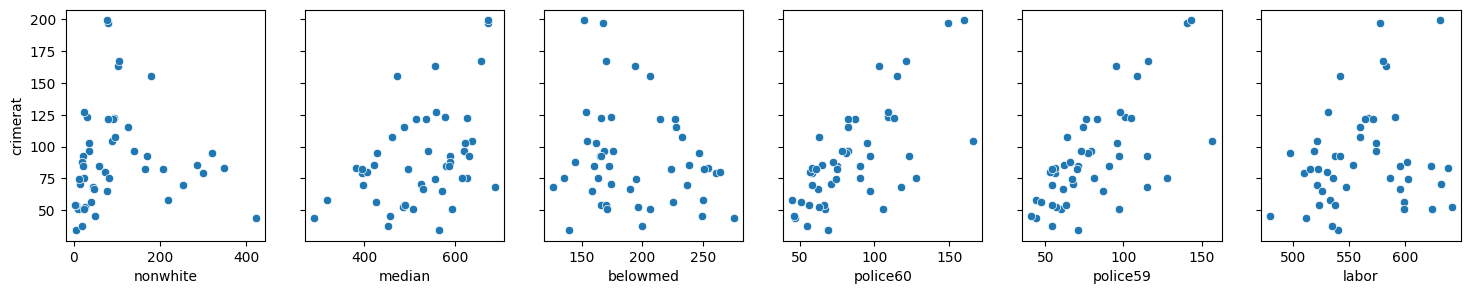

In [100]:
fig, axs = mpl.subplots(1,6,sharey=True,figsize=(18,3))
features = relevant(headers, result, 0)[:6]
for i in range(6):
    sns.scatterplot(x=crime[features[i]],y=crime.crimerat,ax=axs[i])

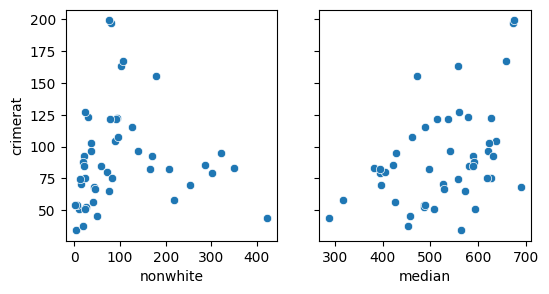

In [102]:
fig, axs = mpl.subplots(1,2,sharey=True,figsize=(6,3))
features = relevant(headers, result, 1)[:2]
for i in range(2):
    sns.scatterplot(x=crime[features[i]],y=crime.crimerat,ax=axs[i])

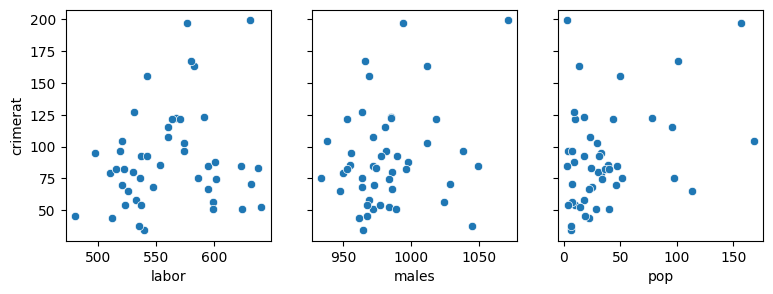

In [103]:
fig, axs = mpl.subplots(1,3,sharey=True,figsize=(9,3))
features = relevant(headers, result, 2)[:3]
for i in range(3):
    sns.scatterplot(x=crime[features[i]],y=crime.crimerat,ax=axs[i])